<a href="https://colab.research.google.com/github/manishmawatwal/DataScience/blob/main/StockMovementClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
#Description: Use stock indicators with Machine Learning to predict stock price

In [16]:
#install the below package
#pip install sklearn

In [17]:
#import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from pandas_datareader import data as web
import requests
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from bokeh.plotting import figure, show

In [18]:
#get stock symbol/tickers in the portfolio
assets = ['GOOG']
#get the stock/portfolio starting date
stockStartDate = '2013-01-01'
#get the ending date
today = datetime.today().strftime('%Y-%m-%d')
#create a dataframe to store the adjusted close price of the stocks
df = pd.DataFrame()

In [19]:
#store the adjusted close price of the stock into the df and display
for stock in assets:
  df[stock] = web.DataReader(stock, data_source='yahoo', start=stockStartDate, end=today)['Close']

#show the df
df

,GOOG
Date,
2013-01-02,360.274597
2013-01-03,360.483826
2013-01-04,367.607117
2013-01-07,366.003143
2013-01-08,365.280823
...,...
2021-05-03,2395.169922
2021-05-04,2354.250000
2021-05-05,2356.739990


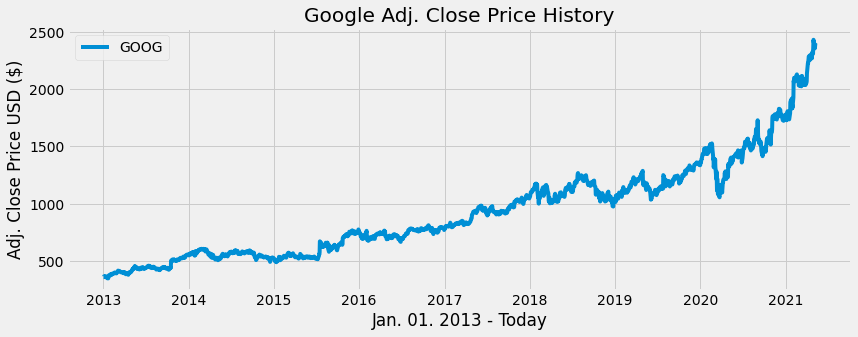

In [20]:
#Visualize the data
plt.figure(figsize=(12.5, 4.5))
plt.plot(df['GOOG'], label = 'GOOG')
plt.title('Google Adj. Close Price History')
plt.xlabel('Jan. 01. 2013 - Today')
plt.ylabel('Adj. Close Price USD ($)')
plt.legend(loc = 'upper left')
plt.show()

In [21]:
#Create functions to calculate the Simple Moving Average (SMA) and Exponnetial Moving Average (EMA)
#typical time period for moving averages are 15, 20, and 30
#create the simple moving average (SMA)
def SMA(data, period = 30, column = 'GOOG'):
  return data[column].rolling(window = period).mean()

#create the exponential moving average (EMA)
def EMA(data, period = 20, column = 'GOOG'):
  return data[column].ewm(span = period, adjust = False).mean()

In [22]:
#create a function to calculate the Moving Average Convergence/Divergence (MACD)
def MACD(data, period_long = 26, period_short = 12, period_signal = 9, column = 'GOOG'):
  #calculate the short term EMA
  ShortEMA = EMA(data, period = period_short, column = column)
  #calculate the long term EMA
  LongEMA = EMA(data, period = period_long, column = column)
  #calculate and store the MACD into the data frame
  data['MACD'] = ShortEMA - LongEMA
  #calculate the signal line and store it into the data frame
  data['Signal_Line'] = EMA(data, period = period_signal, column = 'MACD')

  return data

In [23]:
#create a function to calculate Relative Strength Index (RSI)
def RSI(data, period = 14, column = 'GOOG'):
  delta = data[column].diff(1)
  delta = delta.dropna()
  up = delta.copy()
  down = delta.copy()
  up[up < 0] = 0
  down[down > 0] = 0
  data['up'] = up
  data['down'] = down
  AVG_Gain = SMA(data, period, column = 'up')
  AVG_Loss = abs(SMA(data, period, column = 'down'))
  RS = AVG_Gain / AVG_Loss
  RSI = 100.0 - (100.0 / (1.0 + RS))

  data['RSI'] = RSI
  return data

In [24]:
#Add the indicators to the data set
MACD(df)
RSI(df)
df['SMA'] = SMA(df)
df['EMA'] = EMA(df)
# show the data
df

,GOOG,MACD,Signal_Line,up,down,RSI,SMA,EMA
Date,,,,,,,,
2013-01-02,360.274597,0.000000,0.000000,NaN,NaN,NaN,NaN,360.274597
2013-01-03,360.483826,0.016691,0.003338,0.209229,0.000000,NaN,NaN,360.294524
2013-01-04,367.607117,0.597817,0.122234,7.123291,0.000000,NaN,NaN,360.990961
2013-01-07,366.003143,0.918350,0.281457,0.000000,-1.603973,NaN,NaN,361.468312
2013-01-08,365.280823,1.101394,0.445444,0.000000,-0.722321,NaN,NaN,361.831408
...,...,...,...,...,...,...,...,...
2021-05-03,2395.169922,69.268652,63.500948,0.000000,-14.950195,69.355346,2229.283317,2299.356322
2021-05-04,2354.250000,65.167418,63.834242,0.000000,-40.919922,63.849658,2239.805318,2304.584291
2021-05-05,2356.739990,61.410184,63.349430,2.489990,0.000000,59.400450,2249.931319,2309.551501


In [25]:
#create the Target column
#if tommorrow's close price is gonna increase or decrease 
df['Target'] = np.where(df['GOOG'].shift(-1) > df['GOOG'], 1, 0)
#show the data
df

,GOOG,MACD,Signal_Line,up,down,RSI,SMA,EMA,Target
Date,,,,,,,,,
2013-01-02,360.274597,0.000000,0.000000,NaN,NaN,NaN,NaN,360.274597,1
2013-01-03,360.483826,0.016691,0.003338,0.209229,0.000000,NaN,NaN,360.294524,1
2013-01-04,367.607117,0.597817,0.122234,7.123291,0.000000,NaN,NaN,360.990961,0
2013-01-07,366.003143,0.918350,0.281457,0.000000,-1.603973,NaN,NaN,361.468312,0
2013-01-08,365.280823,1.101394,0.445444,0.000000,-0.722321,NaN,NaN,361.831408,1
...,...,...,...,...,...,...,...,...,...
2021-05-03,2395.169922,69.268652,63.500948,0.000000,-14.950195,69.355346,2229.283317,2299.356322,0
2021-05-04,2354.250000,65.167418,63.834242,0.000000,-40.919922,63.849658,2239.805318,2304.584291,1
2021-05-05,2356.739990,61.410184,63.349430,2.489990,0.000000,59.400450,2249.931319,2309.551501,1


In [26]:
#Remove the first 29 days of data since the RSI and SMA have NaN values
df = df[29:]
#show the data
df

,GOOG,MACD,Signal_Line,up,down,RSI,SMA,EMA,Target
Date,,,,,,,,,
2013-02-13,389.968292,7.042438,5.781522,1.075958,0.000000,68.339454,371.835270,378.920834,1
2013-02-14,392.439056,7.236307,6.072479,2.470764,0.000000,70.689431,372.907419,380.208284,1
2013-02-15,394.964569,7.507200,6.359423,2.525513,0.000000,74.899558,374.056777,381.613644,1
2013-02-19,401.918518,8.188616,6.725262,6.953949,0.000000,77.788187,375.200490,383.547442,0
2013-02-20,394.750366,8.057353,6.991680,0.000000,-7.168152,67.573426,376.158731,384.614387,1
...,...,...,...,...,...,...,...,...,...
2021-05-03,2395.169922,69.268652,63.500948,0.000000,-14.950195,69.355346,2229.283317,2299.356322,0
2021-05-04,2354.250000,65.167418,63.834242,0.000000,-40.919922,63.849658,2239.805318,2304.584291,1
2021-05-05,2356.739990,61.410184,63.349430,2.489990,0.000000,59.400450,2249.931319,2309.551501,1


In [27]:
#split the data set into a feature or independent data set (X) and a Target or dependent data set (Y)
keep_columns = ['GOOG', 'MACD', 'Signal_Line', 'RSI', 'SMA', 'EMA']
X = df[keep_columns].values
Y = df['Target'].values

In [28]:
#split the data again but this time into 80% training and 20% testing data set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 2)

In [29]:
#create and train the decision tree classifier model
tree = DecisionTreeClassifier().fit(X_train, Y_train)

In [30]:
#check how well the model did on the training data set
print(tree.score(X_train, Y_train))

1.0


In [31]:
#check how well the model did on the testing data set
print(tree.score(X_test, Y_test))

0.4987951807228916


In [32]:
#show the model tree predictions
tree_predictions = tree.predict(X_test)
print(tree_predictions)

[0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1
 0 0 1 0 0 0 0 1 0 1 0 1 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 1 1
 1 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 0
 1 1 0 0 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 0
 0 0 0 1 0 0 0 1 1 1 0 1 1 1 0 1 0 1 1 0 0 1 0 1 1 1 1 0 1 0 1 0 0 0 1 1 1
 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 0 1 1 0
 0 0 1 0 1 0 0 1 1 1 1 1 0 0 1 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 0 0
 1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1
 1 1 1 1 0 0 0 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 1
 1 1 0 1 1 1 1 1 0 0 1 0 0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 1 1
 1 0 0 1 0 1 0 1]


In [33]:
#show the actual values from the test data
Y_test

array([1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,

In [34]:
#get the model metrics
from sklearn.metrics import classification_report
print(classification_report(Y_test, tree_predictions))

              precision    recall  f1-score   support

           0       0.47      0.46      0.46       197
           1       0.52      0.54      0.53       218

    accuracy                           0.50       415
   macro avg       0.50      0.50      0.50       415
weighted avg       0.50      0.50      0.50       415

